### Etape 1 : Chargment des librairies
#### Pré-requis : avoir téléchargé sur le https://world.openfoodfacts.org/ le dataset "en.openfoodfacts.org.products.csv"

In [1]:
#Chargement des bibliothèques nécessaire au nettoyage du Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px

### Etape 2 : chargement du dataset à partir du csv téléchargé

In [2]:
#chargement du dataset 
#dataF = pd.read_csv("../DataSet/en.openfoodfacts.org.products.csv", sep="\t", decimal=".")
dataF = pd.read_csv("../DataSet/cleaned_en.openfoodfacts.org.products.csv", sep=";", decimal=",")

/Users/benjamindeplus/.local/share/virtualenvs/OpenFoodFact-L12SYMG1/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (8,9,13,19,20,21,29,30,36,37,38,39,40,41,44,46,47,48,51,53,54,56,63,75,78,79,80,81,82,83,84,85,86,87,88,89,90,91,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,114,115,116,117,118,119,123,124,126,127,128,133,135,136,141,143,144,145,146,147,148,150,152,154,155,156,157,158,159,160,161,162,163,164,165,167,169,171,172,176,178,179,180,181,182) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Etape 3 : Etude de la taille du dataset
Environ **1.5m** de lignes et **183 colonnes**

In [20]:
dataF.shape
dataF.info()
#the data set is 1.5m rows and 180 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449815 entries, 0 to 1449814
Columns: 180 entries, code to carnitine_100g
dtypes: float64(41), int64(2), object(137)
memory usage: 1.9+ GB


Par ailleurs le dataset est essentiellement constitué de colonne de type:
- object cad string (137)
- float64 (41)
- int64 (2)

### Etape 4 de listing des colonnes qui sont vides

empty_cols = [col for col in dataF.columns if dataF[col].isnull().all()]

Nous créons une liste de colonne integralement vide avec la boucle ci-dessus

In [4]:
empty_cols = [col for col in dataF.columns if dataF[col].isnull().all()]
#reset des index dans le dataframe 
dataF = dataF.drop(columns=list(empty_cols)).sort_index()

print("Nombre de lignes:", dataF.shape[0], "Nombre de colonnes", dataF.shape[1])

Nombre de lignes: 1449815 Nombre de colonnes 180


Nom des colonnes vides ['ingredients_from_palm_oil', 'nutrition-score-uk_100g', 'water-hardness_100g']
<br/>Nombre de colonnes vides 3

Enfin nous supprimons ces colonnes inutiles du dataset. 

### Après cette étape le dataset à la forme suivant

Nombre de lignes: 1449815 Nombre de colonnes 180

### Etape 5 suppression des colonnes à double usage

Plusieurs colonnes semblent avoir la même utilité.
Pour limiter la taille du dataset nous allons cleanés les informations dupliqués 
created_t, last_modified_t sont des timestamp de leurs homologues voisines qui sont en datetime



In [22]:
dataF = dataF.drop(columns=["created_t", "last_modified_t"])

### Etape 6 visualisation des colonnes ayant des éléments nulls 
On utilise seaborn pour créer un heatmap avec en x les colonnes et en bleu les valeurs nulls
Par souci de rapidité d'affichage on limile le sample à 10k rows

<AxesSubplot:>

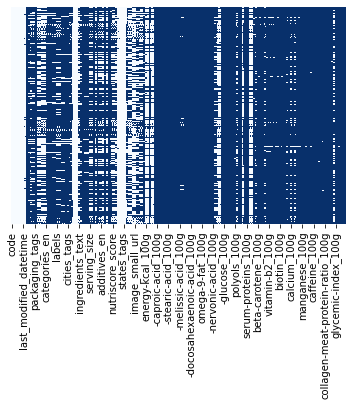

In [7]:
sns.heatmap(dataF.sample(10000).isnull(), yticklabels = False, cbar = False, cmap="Blues")

Comme nous pouvons le constater dans la figure ci-dessus, de nombreuses colonnes semblent pratiquement vide. 
Il serait utile de regarder le taux de remplissage des colonnes du dataset afin de travailler sur des données propres. 

## Etape 7 création d'un dataframe qui sera utilisé comme un filtre 
Nous alons créé un dataframe composé: 
- du nom des colonnes du dataset 
- du taux de remplissage pour cette colonne

Puis nous effectuerons un test pour savoir le nombre de colonne populated à moins de 5%

In [24]:
nonNullRate = []
for col in dataF.columns: 
    #we are counting the row with data and without Null or NaN over the number of rows
    nonNullRate.append({"columns": col, "rate": round((dataF[col].count()/dataF.shape[0])*100, 3)})
nonNullRateFrame = pd.DataFrame(nonNullRate)    
#Etape de filtre
lessThanOnePercentColumns = nonNullRateFrame[nonNullRateFrame["rate"] < 5]
lessThanOnePercentColumns.describe
len(list(lessThanOnePercentColumns["columns"]))

104

104 colonnes sont populated à moins de 5%



### Etape 8 : Suppression des dimensions ayant moins de 5% des lignes populated

Nous effectuons un filtre sur le dataset à l'aide du dataframe 'filtre' créée à l'étape précédente

In [26]:
#list of columns with less than 5% of rows filled
#list(lessThanOnePercentColumns["columns"])
#kill this list of orphane data
cleanDF = dataF.drop(columns=list(lessThanOnePercentColumns["columns"]))
cleanDF.shape

(1449815, 74)

Le dataset se limite desormais à 74 colonnes. Plus de 100 colonnes vides, dupliquées ou peuplées à moins de 5% ont été supprimées. 

### Etape 9 : visualisation des correlations existantes sur les colonnes restantes. 

A cette étape nous essayons de visualiser les correlations du dataset afin d'avoir un premier sentiment sur les liens eventuels existants entre certaines colonnes. 

/Users/benjamindeplus/.local/share/virtualenvs/OpenFoodFact-L12SYMG1/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


<AxesSubplot:>

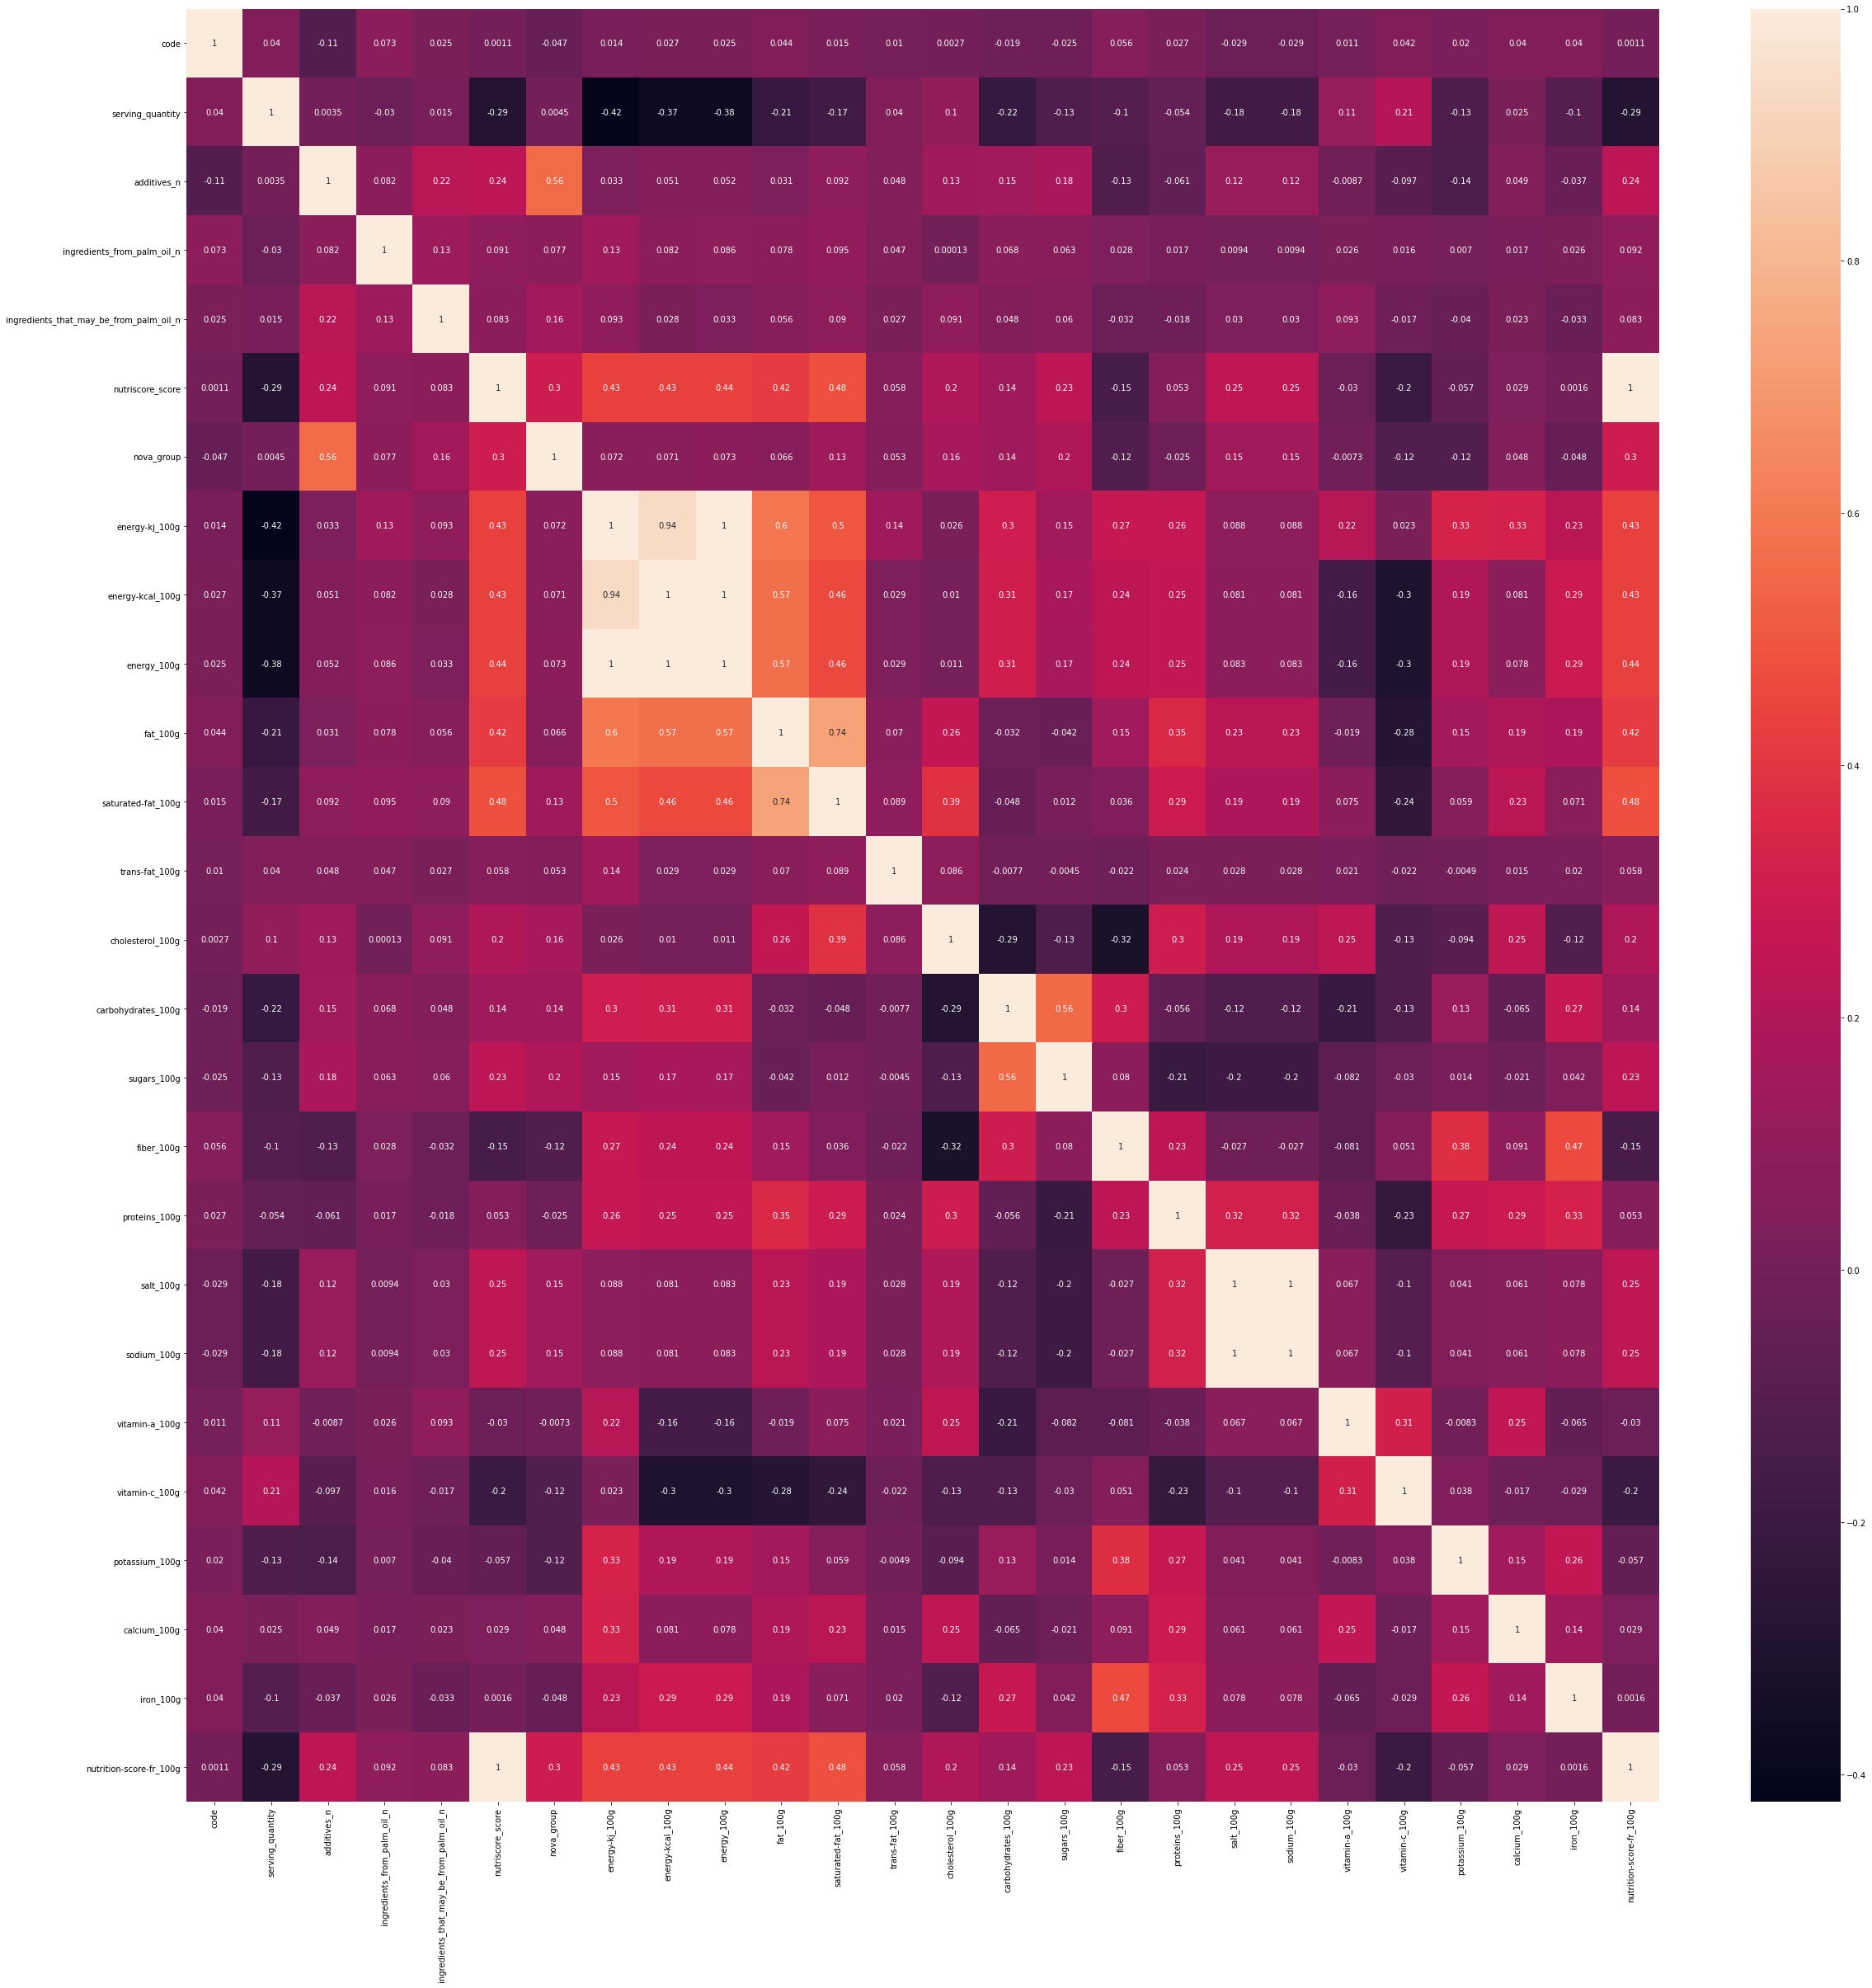

In [28]:
#check correlations 
correlations = cleanDF.corr(method="kendall")
f, ax = plt.subplots(figsize = (40, 40))
#regarder la distance par défault dans heatmap
sns.heatmap(correlations, annot = True)

Plusieurs carrés de correlations apparaissent dans ce heatmap. En effet les valeurs definissant le taux d'une molécule sur 100g semblent être assez correlées. Plusieurs carrés de couleurs s'éloignent du noir qui lui montrent une faible correlation. nutriscore_score semble également resortir du lot en haut à gauche du heatmap et être assez corrélé aux quantités...

### Etape 10 nettoyage des colonnes de type strings
Plusieurs colonnes semblent avoir des valeurs de type string necessitant une intervention pour en limiter le nombre de valeurs distinctes. 


In [32]:
print("brands", cleanDF["brands"].nunique())
print("product_name", cleanDF["product_name"].nunique())
print("pnns_groups_1", cleanDF["pnns_groups_1"].nunique())


brands 137947
product_name 920070
pnns_groups_1 15


In [33]:
#faire avant le nettoyage et après le nettoyage pour une colonne 

stringColumnsToClean = ["brands", "pnns_groups_2", "pnns_groups_1", "product_name", "countries"]

for col in stringColumnsToClean:
    cleanDF[col] = cleanDF[col].str.lower()
    cleanDF[col] = cleanDF[col].str.strip()
    cleanDF[col] = cleanDF[col].replace("é", "e")
    cleanDF[col] = cleanDF[col].replace("è", "e")
    cleanDF[col] = cleanDF[col].replace("à", "a")
    cleanDF[col] = cleanDF[col].replace("-", " ")
print("brands", cleanDF["brands"].nunique())
print("product_name", cleanDF["product_name"].nunique())
print("pnns_groups_1", cleanDF["pnns_groups_1"].nunique())

brands 116569
product_name 849713
pnns_groups_1 15


grâce à ce simple nettoyage: 
- le nombre de marque distinctes a baissé de plus de 200k valeurs 
- le nombre de produits distincts a baissé de près de 100k valeurs 
- pas d'impact sur pnns_group 1 

### Etape 11: création d'un dataframe de filtrage avec le type des colonnes en plus. 

Après ces étapes de nettoyage il serait interessant d'observer : 
- le taux de remplissage des colonnes restantes
- le nombre de valeurs distinctes par colonnes. 

In [35]:
#on the contrary let's have a look for very filled column but with limitated values 
#cleanDF.describe
#low distributed columns but highly filled
nbValues = []
filledRatio = []
columns = []
ColumnsFilledRatio = pd.DataFrame(columns=list(cleanDF.columns), index=["nbValues", "filledRatio"])
for col in cleanDF.columns: 
    columns.append({"column": col, "nbValues": cleanDF[col].nunique(), "type": str(cleanDF[col].dtypes),"filledRatio": round((cleanDF[col].count()/cleanDF.shape[0])*100, 3)})
    nbValues.append(cleanDF[col].nunique())
    filledRatio.append(round((cleanDF[col].count()/cleanDF.shape[0])*100, 3))
ColumnsFilledRatio.append(nbValues)
ColumnsFilledRatio.append(filledRatio)
ColumnsFilledRatio
ColumnsFilledRatioFrame = pd.DataFrame(columns)    
#lets Keep Column filled with less than 50 different values 
#toFocusOnColumns = ColumnsFilledRatio[ColumnsFilledRatio["nbValues"] < 100]
#toFocusOnColumns
#toFocusOnColumns = ColumnsFilledRatio[ColumnsFilledRatio.index.isin(100)]

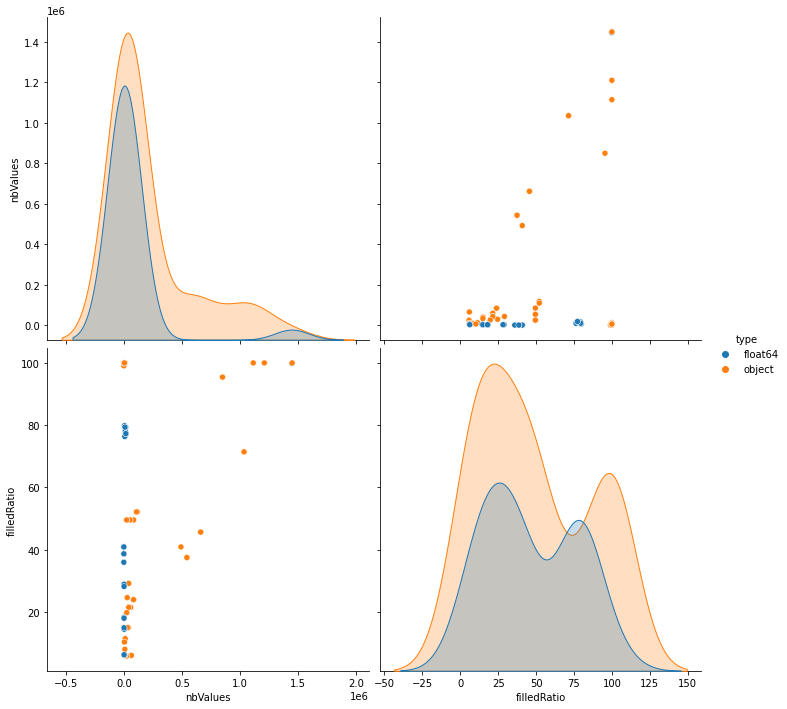

In [36]:
# on peut discretiser les données
#we are espacially interested by variables with higher filled ratios > 70%
#let's filter it 
ColumnsFilledRatioFrameFiltered = ColumnsFilledRatioFrame[ColumnsFilledRatioFrame["filledRatio"] > 30]
#let's visualize it 
sns.pairplot(ColumnsFilledRatioFrame, hue="type", height=5)

### On observe facilement que la majorité des colonnes ayant un très grand nombre de valeur distinctes sont des chaines de caractres (en orange)
On observe également qu'il reste encore un certains nombre de colonnes dont le taux de remplissage est faible.

### Etape 12 nutriscore_score est un bon pivot. 
essayons d'oberver si la presence d'un nutriscore ou non comme filtre permet d'acceder à des données propres. 

Nutriscore est rempli > 38% avec des valeurs comprises entre -15 et 40 et avec des valeurs "Nan".

Par souci d'exploitation de cette colonne nous allons remplacer les NaN par 100

In [39]:
#we now have exploitable data to look at
nutritionScore = ColumnsFilledRatioFrame[ColumnsFilledRatioFrame["column"] == "nutriscore_score"]
ColumnsFilledRatioFrame
#see the minimum value of score 
print("initial", np.unique(cleanDF["nutriscore_score"].values))

cleanDF["nutriscore_score"] = cleanDF["nutriscore_score"].replace(np.nan, 100)
print("après traitement", np.unique(cleanDF["nutriscore_score"].values))

initial [-15. -14. -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.
  -1.   0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.
  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.
  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.
 100.]
après traitement [-15. -14. -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.
  -1.   0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.
  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.
  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.
 100.]


In [40]:
#GET the columns list to drop 
ColumnsFilledRatioFrameFiltered = ColumnsFilledRatioFrame[ColumnsFilledRatioFrame["filledRatio"] < 38]
list(ColumnsFilledRatioFrameFiltered["column"])
cleanLightDF = cleanDF.drop(columns=list(ColumnsFilledRatioFrameFiltered["column"]))

Nous appliquons un filtre sur le dataset et ne gardons que les colonnes remplies à plus de 38% , nutriscore_score inclus. 

### Etape 13 Regardons le dataset en ne gardans que les objets ayant un nutriscore. 

In [43]:
## Etape inutile en utilisant sample à partir du dataframe

cleanLightDFWithScore = cleanLightDF[cleanLightDF["nutriscore_score"] >= -15]
cleanLightDFWithScore = cleanLightDFWithScore[cleanLightDFWithScore["nutriscore_score"] < 100]
sample = np.random.randint(560417, size=100000)
print(cleanLightDFWithScore.shape)
sampledData = cleanLightDFWithScore.sort_index().iloc[list(sample)]

#sns.pairplot(sampledData, height=5, diag_kind="hist")
#cleanLightDFWithScore.to_csv("../DataSet/cleanLightDFWithScore.csv")

(560417, 41)


Le dataset a desormais ~560k rows et 41 colonnes. 

##### Obesrvons à l'aide de Seaborn les dimensions ayant des variables vides dans le dataset traités. 

<AxesSubplot:>

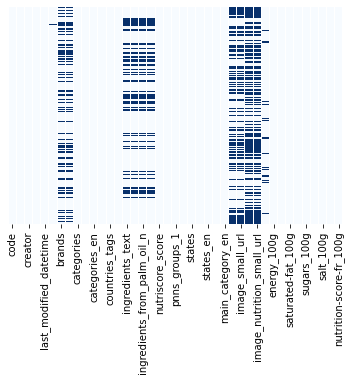

In [44]:
sns.heatmap(cleanLightDFWithScore.isnull(), yticklabels = False, cbar = False, cmap="Blues")


Certaines colonnes sont encore remplies de données null mais dans l'ensemble le substra est plus propre qu'en étape X

### Etape 14 Même approche avec le dataset filtré sur les datas n'ayant pas de nutriscore

Le dataset est beaucoup plus gros ~900k rows

In [45]:
## Etape inutile en utilisant sample à partir du dataframe
#La qualité de la data semble très fortement colérée à la présence d'un nutiscore 
cleanLightDF.columns
cleanLightDFWithOutScore = cleanLightDF[cleanLightDF["nutriscore_score"] == 100]
#sample = np.random.randint(560417, size=100000)
print(cleanLightDFWithOutScore.shape)
#sampledData = cleanLightDFWithOutScore.sort_index().iloc[list(sample)]
#print(sampledData.shape)
#sns.pairplot(sampledData, height=5, diag_kind="hist")
#cleanLightDFWithScore.to_csv("../DataSet/cleanLightDFWithScore.csv")

(889398, 41)


<AxesSubplot:>

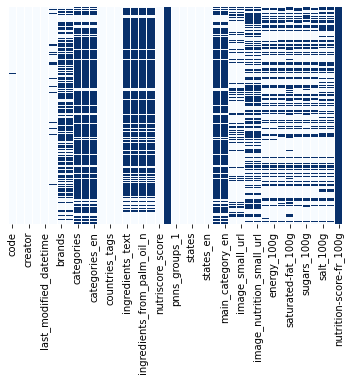

In [46]:
sns.heatmap(cleanLightDFWithOutScore.isnull(), yticklabels = False, cbar = False, cmap="Blues")

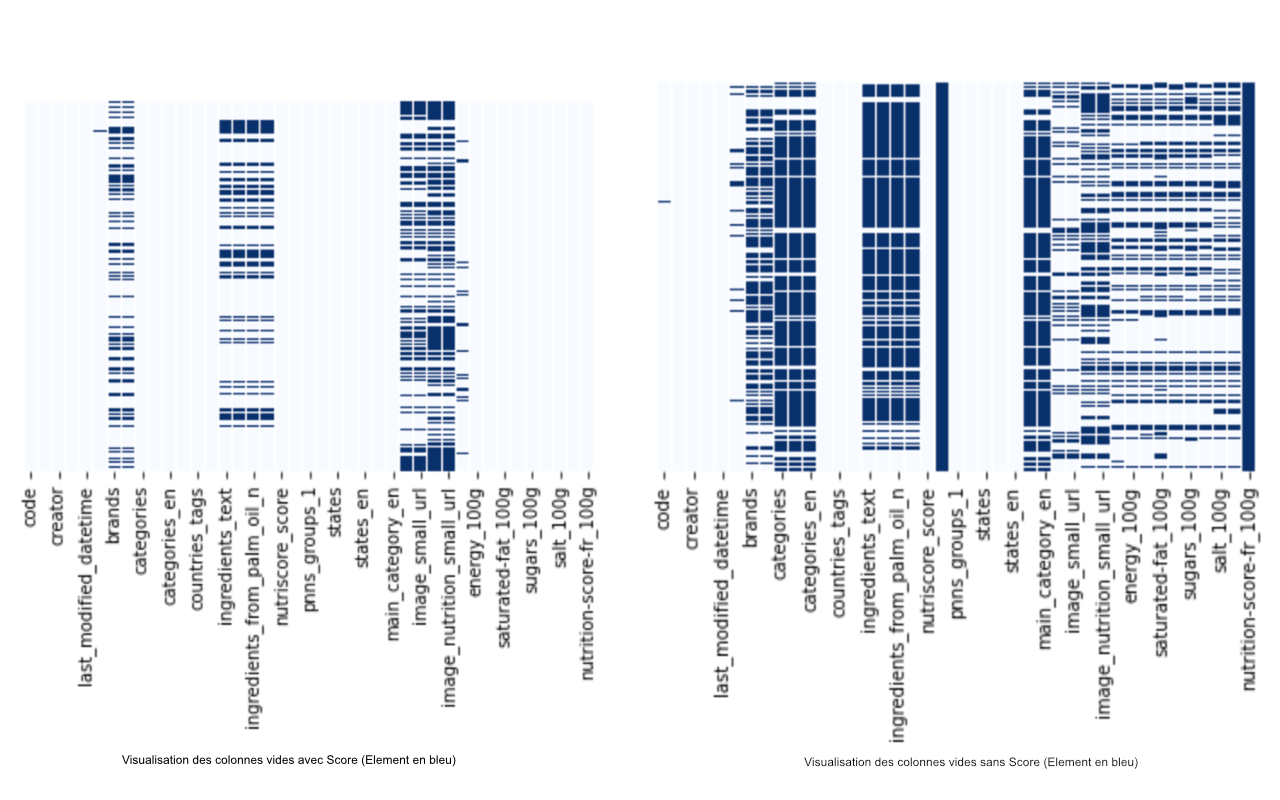

##### On constate visuellement que le dataset filtré avec des éléments ayant un score est beaucoup plus propre ( beaucoup moins de lignes vides) (sur la gauche et en bleu)
##### En revanche le dataset avec des éléments n'ayant pas de score sont extrement impactés par des éléments vides; les données sont très sales. 

Nous allons donc garder uniquement les éléments ayant un nutriscore_score afin de pouvoir travailler sur un maximum d'éléments. 

#### Etape 15 : Préparation à l'export 

Nous allons maintenant exporter un dataset ayant des dimensions remplis avec un score pour avant de passer à l'étape d'exploration ainsi que le dataframe utilisé pour le filtre

Concentrons nous sur les colonnes les plus remplis et qui nous permettrons de trier les produits comme brands ou producte_name ou pnns qui est très complet et est contient peu de valeurs distinctes

### Etape 16 mise à jour du dataframe de triage

Visualisation des caracteristiques des colonnes restantes. 

In [47]:
### mise à jour du dataframe de triage

nbValues = []
filledRatio = []
columns = []
ColumnsFilledRatio = pd.DataFrame(columns=list(cleanLightDFWithScore.columns), index=["nbValues", "filledRatio"])
for col in cleanLightDFWithScore.columns: 
    columns.append({"column": col, "nbValues": cleanLightDFWithScore[col].nunique(), "type": str(cleanLightDFWithScore[col].dtypes),"filledRatio": round((cleanLightDFWithScore[col].count()/cleanLightDFWithScore.shape[0])*100, 3)})
    nbValues.append(cleanLightDFWithScore[col].nunique())
    filledRatio.append(round((cleanLightDFWithScore[col].count()/cleanLightDFWithScore.shape[0])*100, 3))
ColumnsFilledRatio.append(nbValues)
ColumnsFilledRatio.append(filledRatio)
ColumnsFilledRatio
ColumnsFilledRatioFrame = pd.DataFrame(columns)

ColumnsFilledRatioFrame[ColumnsFilledRatioFrame["type"] == "object"].sort_values(by=["filledRatio", "nbValues"], ascending=False)

,column,nbValues,type,filledRatio
1,url,560416,object,100.000
3,created_datetime,404644,object,100.000
4,last_modified_datetime,370398,object,100.000
25,main_category,17876,object,100.000
2,creator,7159,object,100.000
23,states_tags,1708,object,100.000
24,states_en,1708,object,100.000
22,states,1707,object,100.000
21,pnns_groups_2,41,object,100.000
19,nutriscore_grade,5,object,100.000


In [48]:
cleanLightDFWithScore.to_csv("../Projet Final/DataSet/cleanLightDFWithScore.csv", index= False)
ColumnsFilledRatioFrame.to_csv("../Projet Final/DataSet/ColumnsFilledRatioFrame.csv", index=False)

In [50]:
cleanLightDFWithScore.shape
ColumnsFilledRatioFrame.shape

(41, 4)

#### Etape 17 verification de la forme des dataframes exportés. 

cleanLightDFWithScore a une shape de 560417 rows et 41 colonnes
ColumnsFilledRatioFrame a une shape de 41 rows et 4 colonnes

### Go to PSanté_02_notebook_exploration for Exploration